In [1]:
import os
import sys
import urllib, io

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/Users/will/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['perceptual_chunks']

# which iteration name should we use?
iterationName = 'dev'

# variables to check integrity of data
# numTrials = 24

In [4]:
query = coll.find()
df_test = pd.DataFrame(list(query.sort('timeAbsolute')))
df_test.iloc[-10:,:]

,_id,email,projectName,experimentName,iterationName,anonymizeCSV,bonusAmt,dataStore,numHorizontalCells,numVerticalCells,...,devMode,trialText,successCondition,timeReset,trialStart,comments,strategy,totalLength,didCorrectly,color
1810,5fd01b1f6d753116720da3d0,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1811,5fd01b206d753116720da3d1,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1812,5fd01b216d753116720da3d2,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1813,5fd01b236d753116720da3d3,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1814,5fd01b246d753116720da3d4,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1815,5fd01b256d753116720da3d5,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1816,5fd01b256d753116720da3d6,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1817,5fd01b266d753116720da3d7,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1818,5fd01b276d753116720da3d8,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
1819,5fd01b2b6d753116720da3d9,NaN,NaN,NaN,test_naive,NaN,NaN,NaN,NaN,NaN,...,False,,None,1.607474e+12,1.607474e+12,wef,wef,13904.0,No,No


## Trial Types

In [47]:
# trial end 
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'trialEnd'}]
                     })
df_test = pd.DataFrame(list(query.sort('timeAbsolute')))
df_test.iloc[-5:,:]

,_id,trialNum,targetName,bitmap,stimGrid,nReset,iterationName,absoluteTime,eventType,gameGrid,...,devMode,trialText,successCondition,timeReset,trialStart,trialStartTime,gameID,gameStartTime,relativeGameDuration,relativeTrialDuration
180,5fd018d06d753116720da3ca,1,hand_selected_012,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,test_naive,1.607473e+12,trialEnd,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",...,False,,NaN,1.607473e+12,1.607473e+12,NaN,NaN,NaN,NaN,NaN
181,5fd01b016d753116720da3ce,1,hand_selected_012,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,test_naive,1.607474e+12,trialEnd,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",...,False,,NaN,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
182,5fd01b276d753116720da3d8,1,hand_selected_012,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,test_naive,1.607474e+12,trialEnd,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",...,False,,NaN,1.607474e+12,1.607474e+12,NaN,NaN,NaN,NaN,NaN
183,5fd0e44a6d753116720da3e4,1,hand_selected_012,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,test_naive,1.607525e+12,trialEnd,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",...,False,,NaN,1.607525e+12,1.607525e+12,NaN,NaN,NaN,NaN,NaN
184,5fd0e7636d753116720da3ee,1,hand_selected_012,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,test_naive,1.607526e+12,trialEnd,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",...,False,,NaN,1.607526e+12,NaN,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,14553.0,14575.0


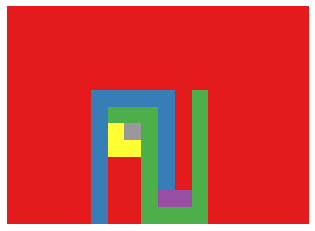

In [50]:
chunks = df_test.loc[183,'gameGrid']

av_map = np.rot90(chunks)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(av_map, cmap='Set1')

In [33]:
# color change 
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'colorChange'}]
                     })
df_test = pd.DataFrame(list(query.sort('timeAbsolute')))
df_test.iloc[-5:,:]

,_id,trialType,trialNum,targetName,trialText,successCondition,bitmap,stimGrid,nReset,timeReset,...,squaresSelected,nSquaresSelected,nSquaresChanged,totalChunkSize,newColorGroup,trialStartTime,gameID,gameStartTime,relativeGameDuration,relativeTrialDuration
13,5fd0e7606d753116720da3e9,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607526e+12,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",16,16,16,4,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,11209.0,11231.0
14,5fd0e7606d753116720da3ea,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607526e+12,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",2,2,2,5,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,11926.0,11948.0
15,5fd0e7616d753116720da3eb,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607526e+12,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",1,1,1,6,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,12309.0,12331.0
16,5fd0e7616d753116720da3ec,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607526e+12,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",1,1,1,7,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,12692.0,12714.0
17,5fd0e7626d753116720da3ed,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607526e+12,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",4,4,4,8,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,13743.0,13765.0


In [17]:
# survey 
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'survey'}]
                     })
df_test = pd.DataFrame(list(query.sort('timeAbsolute')))
df_test.iloc[-5:,:]

,_id,trialType,trialNum,targetName,trialText,successCondition,bitmap,stimGrid,nReset,timeReset,...,comments,strategy,didCorrectly,color,totalLength,trialStartTime,gameID,gameStartTime,relativeGameDuration,relativeTrialDuration
0,5fd0e44f6d753116720da3e5,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607525e+12,...,awef,fwaf,No,Yes,19775,NaN,NaN,NaN,NaN,NaN
1,5fd0e76b6d753116720da3ef,normal-trial,1,hand_selected_012,,None,"[[1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0,1.607526e+12,...,awrv,cawev,I was confused,No,22199,1.607526e+12,2674-d72d4e75-557b-8761-94b3-38ca051a6bcd,1.607526e+12,22199.0,22221.0


## Sanity Checks

In [36]:
# Ensure one to one gameID and workerId 
# Should only happen if a repeat worker gets through

query = coll.find({"$and":[
                        {'workerId':{'$exists':True}},
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'trial_end'},
                        {"$or":[{'iterationName':'pilot2'},
                                {'iterationName':'pilot3'},
                                {'iterationName':'pilot4'},
                                {'iterationName':'Exp2Pilot1'},
                                {'iterationName':'Exp2Pilot1_turk'},
                                {'iterationName':'Exp2Pilot1_turk'}]},
                        {'trialNum':0}]
                     })

df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))
#df_trial_end_full[['workerId','gameID']]


assert (np.mean(df_trial_end_full['workerId'].value_counts()) == np.mean(df_trial_end_full['gameID'].value_counts()))

KeyError: 'workerId'

## Trial Level Data

In [196]:
# Assuming that if trial 23 saves, then 0-22 have also saved 
# get ids of people with trial 23 data
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'trial_end'},
                        {"$or":[{'iterationName':'Exp2Pilot3'},
                                {'iterationName':'Exp2Pilot3_batch2'}]},
                        #{'iterationName': iterationName}, #use this if one iteration name
                        {'trialNum': numTrials-1}]
                     })
complete_data_df = pd.DataFrame(query)
complete_data_ids = list(complete_data_df['workerId'])

In [197]:
# Filter for full datasets
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'trial_end'},
                        #{'iterationName': iterationName}, #use this if one iteration name
                        {"$or":[{'iterationName':'Exp2Pilot3'},
                                {'iterationName':'Exp2Pilot3_batch2'}]}]
                     })

df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))


# filter dataframe for complete datasets
df_trial_end_full_filtered = df_trial_end_full[df_trial_end_full.workerId.isin(complete_data_ids)]

# reduce to crucial information
df_trial_end_reduced_filtered = df_trial_end_full_filtered[[
    'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID', #trial identifiers
    'nullScore','F1Score','normedScore','rawScoreDiscrete','nullScoreDiscrete','normedScoreDiscrete','scoreGapDiscrete', #scoring
    'numBlocks','nPracticeAttempts','blockColor','blockColorID','blockFell','doNothingRepeats',#misc. trial info
    'score','currBonus','timeBonus', #bonusing
    'timeAbsolute','timeRelative','buildTime','buildStartTime','buildFinishTime','timeToBuild', #timing 
    'discreteWorld','allVertices', #world reconstruction
    'browser','browserVersion','os','devMode', #developer info
    #below here should be the same for every trial in a dataset
    'iterationName',
    'numTargets', 'prePostSetSize','numRepetitions', #pre-post info
    'bonusThresholdLow','bonusThresholdMid','bonusThresholdHigh','timeThresholdYellow','timeThresholdRed', #bonus info
    ]]

#Fix error in data-saving- normedScoreDiscrete saved as rawScoreDiscrete
df_trial_end_reduced_filtered['normedScoreDiscrete'] = df_trial_end_reduced_filtered['rawScoreDiscrete']
df_trial_end_reduced_filtered.drop(['rawScoreDiscrete'], axis=1)


df = df_trial_end_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Compute Spatial Reconstruction Accuracy

In [198]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)

In [199]:
def getPrecision(arr1,arr2):
    prod = np.multiply(arr1,arr2)
    false_pos = np.subtract(arr2,prod)
    numerator = np.sum(prod)
    denominator = np.add(numerator,np.sum(false_pos))
    recall = numerator/denominator
    return recall

def getRecall(arr1,arr2):
    prod = np.multiply(arr1,arr2)
    false_neg = np.subtract(arr1,prod)
    numerator = np.sum(prod)
    denominator = np.add(np.sum(prod),np.sum(false_neg))
    recall = numerator/denominator
    return recall

def getF1Score(targetName, discreteWorld):
    targetMap = targetMaps[targetName]
    arr1 = 1*np.logical_not(np.array(targetMap))
    arr2 = 1*np.logical_not(np.array(discreteWorld))
    recall = getRecall(arr1, arr2)
    precision = getPrecision(arr1, arr2)
    numerator = np.multiply(precision, recall)
    denominator = np.add(precision, recall)
    if (denominator>0):
        quotient = np.divide(numerator, denominator)
        f1Score = np.multiply(2, quotient)
    else:
        f1Score = 0
#     print('recall ' + str(recall))
#     print('precision ' + str(precision))
    return f1Score

def getF1ScoreLambda(row):
    return(getF1Score(row['targetName'], row['discreteWorld']))


def getJaccard(targetName, discreteWorld):
    targetMap = targetMaps[targetName]
    arr1 = 1*np.logical_not(np.array(targetMap))
    arr2 = 1*np.logical_not(np.array(discreteWorld))
    
    prod = np.multiply(arr1,arr2)
    true_pos = np.sum(prod)
    false_pos = np.sum(np.subtract(arr2,prod))
    false_neg = np.sum(np.subtract(arr1,prod))
#     print(true_pos)
#     print(false_pos)
#     print(false_neg)

    denomenator = np.add(false_neg,np.add(false_pos,true_pos))
    jaccard = np.divide(true_pos,denomenator)
    #print('recall ' + recall);
    return jaccard

def getJaccardLambda(row):
    return(getJaccard(row['targetName'], row['discreteWorld']))

# def getNullScore(targetName):
#     targetMap = targetMaps[targetName]
#     arr1 = 1*np.logical_not(np.array(targetMap))
#     arr2 = 1*np.zeros(arr1.shape)
#     recall = getRecall(arr1, arr2)
#     precision = getPrecision(arr1, arr2)
#     numerator = np.multiply(precision, recall)
#     denominator = np.add(precision, recall)
#     quotient = np.divide(numerator, denominator)
#     f1Score = np.multiply(2, quotient)
#     print('recall ', str(recall));
#     print('precision ', str(precision));
#     print('quotient ', str(quotient));
#     return f1Score

In [200]:
df['rawF1DiscreteScore'] =  df.apply(getF1ScoreLambda, axis=1)

In [201]:
df['jaccardDiscrete'] = df.apply(getJaccardLambda, axis=1)

In [202]:
# Make new column: phase_extended
# Same as phase but with 'repeated' split into 'repetition 1' and 'repetition 2'

phase_dict = {
    'pre':0,
    'repetition 1':1,
    'repetition 2':2,
    'post':3
}

ordered_phases = ['pre','repetition 1','repetition 2','post']


df['phase_extended'] = df['phase']
df.loc[(df.phase=='repeated') & (df.repetition==1),'phase_extended'] = 'repetition 1'
df.loc[(df.phase=='repeated') & (df.repetition==2),'phase_extended'] = 'repetition 2'


df['phase_number'] = df.phase_extended.astype("category").cat.set_categories(ordered_phases).cat.codes + 1

In [203]:
#Add useful variables for graphing

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])
df['perfectScore'] = df.rawF1DiscreteScore == 1

In [204]:
df['gameID'].nunique()

107

## Initial Block Data
Initial block placements (before physics, after snapping, before falling)

In [205]:
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'initial'},
                        #{'iterationName': iterationName}, #use this if one iteration name
                        {"$or":[{'iterationName':'Exp2Pilot3'},
                                {'iterationName':'Exp2Pilot3_batch2'}]}]
                     })

df_initial_full = pd.DataFrame(list(query))

# filter dataframe for complete datasets
df_initial_full_filtered = df_initial_full[df_initial_full.workerId.isin(complete_data_ids)]

print('Loaded ' + str(df_initial_full_filtered.shape[0]) + ' complete sets of initial blocks')
# reduce to crucial information

Loaded 23042 complete sets of initial blocks


In [206]:
df_initial_full_filtered.columns

Index(['_id', 'iterationName', 'workerId', 'hitID', 'aID', 'gameID', 'version',
       'randID', 'timeRelative', 'timeAbsolute', 'phase', 'condition',
       'trialNum', 'nullScore', 'scoreGap', 'F1Score', 'normedScore',
       'rawScoreDiscrete', 'normedScoreDiscrete', 'nullScoreDiscrete',
       'scoreGapDiscrete', 'currBonus', 'score', 'points', 'numTrials',
       'targetName', 'targetBlocks', 'prompt', 'blockColors', 'blockColor',
       'blockColorID', 'numTargets', 'prePostSetSize', 'numRepetitions',
       'repetition', 'targetID', 'practiceDuration', 'buildDuration',
       'timeThresholdYellow', 'timeThresholdRed', 'devMode',
       'discreteEnvHeight', 'discreteEnvWidth', 'browser', 'browserVersion',
       'os', 'canvasHeight', 'canvasWidth', 'menuHeight', 'menuWidth',
       'floorY', 'stimCanvasWidth', 'stimCanvasHeight', 'stimX', 'stimY',
       'scalingFactor', 'worldScale', 'stim_scale', 'allBlockDims',
       'worldWidthUnits', 'worldHeightUnits', 'blockOptions', 'flo

In [207]:
df_initial_reduced_filtered = df_initial_full_filtered[[
    'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID','blockNum', #trial identifiers
    'nullScore','incrementalScore','normedIncrementalScore','rawScoreDiscrete','incrementalNormedScoreDiscretePrevious', #scoring
    'score','currBonus', #bonusing
    'timeAbsolute','timeRelative','timeBlockSelected','timeBlockPlaced','relativePlacementTime', #timing 
    'discreteWorld','vertices','blockKind','blockColorID','blockColor','blockCenterX', 'blockCenterY', #world reconstruction
    'x_index','y_index','x_discrete','y_discrete','width_discrete','height_discrete'
    ]]

df_initial_reduced_filtered = df_initial_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

In [208]:
dfi = df_initial_reduced_filtered

In [209]:
dfi['phase_extended'] = dfi['phase']
dfi.loc[(dfi.phase=='repeated') & (dfi.repetition==1),'phase_extended'] = 'repetition 1'
dfi.loc[(dfi.phase=='repeated') & (dfi.repetition==2),'phase_extended'] = 'repetition 2'


# dfi['phase_number'] = dfi.phase_extended.astype("category",
#                                               ordered=True,
#                                               categories=ordered_phases).cat.codes


In [210]:
dfi['rawF1DiscreteScore'] =  dfi.apply(getF1ScoreLambda, axis=1)

## Settled Block Data
Block data after coming to rest (after physics)

In [211]:
query = coll.find({"$and":[
                        {'condition':{'$ne':'practice'}},
                        {'eventType':'settled'},
                        #{'iterationName': iterationName}, #use this if one iteration name
                        {"$or":[{'iterationName':'Exp2Pilot3'},
                                {'iterationName':'Exp2Pilot3_batch2'}]}]
                     })

df_settled_full = pd.DataFrame(list(query))


# filter dataframe for complete datasets
df_settled_full_filtered = df_settled_full[df_settled_full.workerId.isin(complete_data_ids)]

print('Loaded ' + str(df_settled_full_filtered.shape[0]) + ' complete sets of settled blocks')
# reduce to crucial information

Loaded 23093 complete sets of settled blocks


In [212]:
df_settled_full_filtered.columns

Index(['_id', 'iterationName', 'workerId', 'hitID', 'aID', 'gameID', 'version',
       'randID', 'timeRelative', 'timeAbsolute', 'phase', 'condition',
       'trialNum', 'nullScore', 'scoreGap', 'F1Score', 'normedScore',
       'rawScoreDiscrete', 'normedScoreDiscrete', 'nullScoreDiscrete',
       'scoreGapDiscrete', 'currBonus', 'score', 'points', 'numTrials',
       'targetName', 'targetBlocks', 'prompt', 'blockColors', 'blockColor',
       'blockColorID', 'numTargets', 'prePostSetSize', 'numRepetitions',
       'repetition', 'targetID', 'practiceDuration', 'buildDuration',
       'timeThresholdYellow', 'timeThresholdRed', 'devMode',
       'discreteEnvHeight', 'discreteEnvWidth', 'browser', 'browserVersion',
       'os', 'canvasHeight', 'canvasWidth', 'menuHeight', 'menuWidth',
       'floorY', 'stimCanvasWidth', 'stimCanvasHeight', 'stimX', 'stimY',
       'scalingFactor', 'worldScale', 'stim_scale', 'allBlockDims',
       'worldWidthUnits', 'worldHeightUnits', 'blockOptions', 'flo

In [213]:
df_settled_reduced_filtered = df_settled_full_filtered[[
    'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID', #trial identifiers
    'nullScore','incrementalScore','normedIncrementalScore','rawScoreDiscrete','incrementalNormedScoreDiscrete','numBlocks','blockFell', #scoring
    'score','currBonus', #bonusing
    'timeAbsolute','timeRelative',#timing 
    'discreteWorld','allVertices','blockKind','blockColorID','blockColor','blockCenterX', 'blockCenterY',#world reconstruction
    'x_index','y_index','x_discrete','y_discrete'
    ]]

df_settled_reduced_filtered = df_settled_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

In [214]:
dfs = df_settled_reduced_filtered

In [215]:
dfs['rawF1DiscreteScore'] =  dfs.apply(getF1ScoreLambda, axis=1)

## Survey Data

In [4]:
query = coll.find({"$and":[
                        {'eventType':'survey_data'},
                        #{'iterationName': iterationName}, #use this if one iteration name
                        {"$or":[{'iterationName':'Exp2Pilot3'},
                                {'iterationName':'Exp2Pilot3_batch2'}]}]
                     })
df_survey = pd.DataFrame(list(query.sort('absoluteTime')))
df_survey[['gameID','age','comments','difficulty','fun','strategies','inputDevice','sex','score']]

,gameID,age,comments,difficulty,fun,strategies,inputDevice,sex,score
0,1691-3673775e-bf17-46c9-b775-79afc1355b02,28,"Hard! Much harder than I expected! I loved it,...",6,7,Unfortunately I didn't.,Mouse,Male,0.325
1,6834-b18d5535-d036-4aa4-bd46-e31404e1a9b0,50,It was vry diificult nut fun I like to use ny ...,6,7,A good base and trying to pay attention to det...,Trackpad,Female,0.090
2,9415-40177ff4-0b4d-494c-96b4-3409ff007cdb,28,I enjoyed the hit.,4,6,I just saw which piece will be suitable for th...,Mouse,Female,0.070
3,6679-27a62967-b9d8-4a25-8b63-74e16e2f7f32,30,"It was fine, no issues",2,5,redrawing the pattern by imagining that I was ...,Mouse,Female,0.635
4,0823-6fe08630-db1c-47e9-b895-7a2bf343bb77,43,"Frustrating at first, but got the hang of it a...",5,6,Not really. Started from the bottom and would...,Mouse,Male,0.805
...,...,...,...,...,...,...,...,...,...
102,9805-bd7d85df-736b-4dc5-bfc6-2ecb499073f1,42,Good Experiment,3,6,No,Mouse,Male,0.660
103,0932-497aa71d-ab24-43b1-9807-f93430084a41,61,"No issues. Sort of fun, but I no longer do ver...",6,5,Go as quickly as possible with fewest errors!,Mouse,Female,0.725
104,7057-10c550d8-ab37-4777-9ee9-6536757b5b0e,39,It was a very fun game. Thank you for the opp...,4,6,I tried to work from the ground up.,Mouse,Female,0.520
105,9904-fd1ea2a0-3285-4217-b686-40c4ad8c5362,30,good study,4,5,nothing,Mouse,Male,0.010


## Data Cleaning (bugs)

In [217]:
# Remove two block placements (potentially from refreshing?)
# These were recorded but don't seem to be a part of the final structure
# Believe they are from refreshing

dfi = dfi[~(((dfi.gameID == '4611-415301bd-3cd2-4751-9911-e530d1bce758') & 
        (dfi.trialNum==1) & 
        (dfi.blockNum == 1) & 
        (dfi.blockKind=='D')) |
    ((dfi.gameID == '2328-cf96d18d-a95b-4d1b-bc43-602ee1bf5835') & 
        (dfi.trialNum==0) & 
        (dfi.blockNum == 1) & 
        (dfi.blockKind=='E')))]

dfs = dfs[~(((dfi.gameID == '4611-415301bd-3cd2-4751-9911-e530d1bce758') & 
        (dfs.trialNum==1) & 
        (dfs.numBlocks == 1) & 
        (dfs.blockKind=='D')) |
    ((dfs.gameID == '2328-cf96d18d-a95b-4d1b-bc43-602ee1bf5835') & 
        (dfs.trialNum==0) & 
        (dfs.numBlocks == 1) & 
        (dfs.blockKind=='E')))]

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [218]:
# Mark a participant as buggy

df['buggy'] = False
dfs['buggy'] = False
dfi['buggy'] = False
df_survey['buggy'] = False

#Mark this participant as bugs found leading to >60s build time. Perhaps a very slow computer?
df.loc[df.gameID=="3988-e15c8e2e-0b53-43fd-a2d3-686d3efd6923",'buggy'] = True 
dfs.loc[dfs.gameID=="3988-e15c8e2e-0b53-43fd-a2d3-686d3efd6923",'buggy'] = True 
dfi.loc[dfi.gameID=="3988-e15c8e2e-0b53-43fd-a2d3-686d3efd6923",'buggy'] = True
df_survey.loc[df_survey.gameID=="3988-e15c8e2e-0b53-43fd-a2d3-686d3efd6923",'buggy'] = True

#Mark this participant as NaNs found for two scores.
df.loc[df.gameID=="4739-25f27c31-0d4c-46ae-a515-02351c69042d",'buggy'] = True 
dfs.loc[dfs.gameID=="4739-25f27c31-0d4c-46ae-a515-02351c69042d",'buggy'] = True 
dfi.loc[dfi.gameID=="4739-25f27c31-0d4c-46ae-a515-02351c69042d",'buggy'] = True 
df_survey.loc[df_survey.gameID=="4739-25f27c31-0d4c-46ae-a515-02351c69042d",'buggy'] = True

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/will/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [5]:
df_survey['buggy'] = False
df_survey.loc[df_survey.gameID=="3988-e15c8e2e-0b53-43fd-a2d3-686d3efd6923",'buggy'] = True
df_survey.loc[df_survey.gameID=="4739-25f27c31-0d4c-46ae-a515-02351c69042d",'buggy'] = True

## Inter-block-interval

In [219]:
def getMeanIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.mean(ibis)

def getMedianIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.median(ibis)


def getSDIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.std(ibis)

def getMinIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.min(ibis)

In [220]:
dfi = dfi.drop_duplicates(subset=['gameID','trialNum','blockNum'], keep='last')

dfIBIMean = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMeanIBI).reset_index()
dfIBIMean = dfIBIMean.rename(columns = {'relativePlacementTime':'meanIBI'})
df = pd.merge(df, dfIBIMean, how='left', on=['gameID','trialNum'])

dfIBIMin = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMinIBI).reset_index()
dfIBIMin = dfIBIMin.rename(columns = {'relativePlacementTime':'minIBI'})
df = pd.merge(df, dfIBIMin, how='left', on=['gameID','trialNum'])

thinking_time = dfi[dfi.blockNum==1][['gameID','trialNum','relativePlacementTime']]
thinking_time = thinking_time.rename(columns = {'relativePlacementTime':'thinkingTime'})
df = pd.merge(df, thinking_time, how='left', on=['gameID','trialNum'])

dfIBIMedian = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMedianIBI).reset_index()
dfIBIMedian = dfIBIMedian.rename(columns = {'relativePlacementTime':'medianIBI'})
df = pd.merge(df, dfIBIMedian, how='left', on=['gameID','trialNum'])

dfIBISD = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getSDIBI).reset_index()
dfIBISD = dfIBISD.rename(columns = {'relativePlacementTime':'sdIBI'})
df = pd.merge(df, dfIBISD, how='left', on=['gameID','trialNum'])

In [186]:
df_trial_end_full_filtered

,_id,iterationName,workerId,hitID,aID,gameID,version,randID,timeRelative,timeAbsolute,...,timeBonus,buildResets,nPracticeAttempts,doNothingRepeats,bonusThresholdHigh,bonusThresholdMid,bonusThresholdLow,allVertices,blockFell,discreteWorld
0,5e29e4af280c353fe062def4,Exp2Pilot3,A2ZDEERVRN5AMC,3GKAWYFRAP703ZGRDT02TKJV75BDPZ,3TK8OJTYM2ZPK0E7UG5YOQKND83PVA,1691-3673775e-bf17-46c9-b775-79afc1355b02,82,bf1s3yl8mc71q5nq87437,205017.000,1.579804e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 495.03332757742515, 'y': 482.758686556...",False,"[[True, True, True, True, True, True, True, Tr..."
1,5e29e4f5280c353fe062deff,Exp2Pilot3,A2ZDEERVRN5AMC,3GKAWYFRAP703ZGRDT02TKJV75BDPZ,3TK8OJTYM2ZPK0E7UG5YOQKND83PVA,1691-3673775e-bf17-46c9-b775-79afc1355b02,82,bf1s3yl8mc71q5nq87437,274513.000,1.579804e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 495.1287875876538, 'y': 592.5522983949...",True,"[[True, True, True, True, True, True, True, Tr..."
2,5e29e535280c353fe062df16,Exp2Pilot3,A2ZDEERVRN5AMC,3GKAWYFRAP703ZGRDT02TKJV75BDPZ,3TK8OJTYM2ZPK0E7UG5YOQKND83PVA,1691-3673775e-bf17-46c9-b775-79afc1355b02,82,bf1s3yl8mc71q5nq87437,338985.000,1.579804e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 440, 'y': 592.5931362597067}, {'x': 66...",False,"[[True, True, True, True, True, True, True, Tr..."
3,5e29e576280c353fe062df2f,Exp2Pilot3,A2ZDEERVRN5AMC,3GKAWYFRAP703ZGRDT02TKJV75BDPZ,3TK8OJTYM2ZPK0E7UG5YOQKND83PVA,1691-3673775e-bf17-46c9-b775-79afc1355b02,82,bf1s3yl8mc71q5nq87437,403762.000,1.579804e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 384.91373972159863, 'y': 592.776560928...",False,"[[True, True, True, True, True, True, True, Tr..."
4,5e29e5b8280c353fe062df40,Exp2Pilot3,A2ZDEERVRN5AMC,3GKAWYFRAP703ZGRDT02TKJV75BDPZ,3TK8OJTYM2ZPK0E7UG5YOQKND83PVA,1691-3673775e-bf17-46c9-b775-79afc1355b02,82,bf1s3yl8mc71q5nq87437,469553.000,1.579804e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 439.98034412015824, 'y': 592.818840595...",False,"[[True, True, True, True, True, True, True, Tr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,5eb446ba346be0546b2922e1,Exp2Pilot3_batch2,A17LZ3WK12T7CJ,31ANT7FQN8GDM53AFAAEMZTCAR35H4,3Z7ISHFUH19LNSK09WSQNA2ULJ4Z8Q,0873-2851611f-42e5-4913-979c-1148321ce97a,82,o8u3wicj9nuynz5xya8ak,1544658.790,1.588873e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 549.8424054564126, 'y': 593.0763798294...",False,"[[True, True, True, True, True, True, True, Tr..."
1463,5eb446fa346be0546b2922ea,Exp2Pilot3_batch2,A17LZ3WK12T7CJ,31ANT7FQN8GDM53AFAAEMZTCAR35H4,3Z7ISHFUH19LNSK09WSQNA2ULJ4Z8Q,0873-2851611f-42e5-4913-979c-1148321ce97a,82,o8u3wicj9nuynz5xya8ak,1608964.355,1.588873e+12,...,0.000,0,None,0,0.95,0.88,0.75,"[[{'x': 440.07474003845846, 'y': 592.148612905...",True,"[[True, True, True, True, True, True, True, Tr..."
1464,5eb44722346be0546b2922f9,Exp2Pilot3_batch2,A17LZ3WK12T7CJ,31ANT7FQN8GDM53AFAAEMZTCAR35H4,3Z7ISHFUH19LNSK09WSQNA2ULJ4Z8Q,0873-2851611f-42e5-4913-979c-1148321ce97a,82,o8u3wicj9nuynz5xya8ak,1648566.480,1.588873e+12,...,0.005,0,None,0,0.95,0.88,0.75,"[[{'x': 439.8840621744056, 'y': 592.7538103770...",False,"[[True, True, True, True, True, True, True, Tr..."
1465,5eb44752346be0546b29230e,Exp2Pilot3_batch2,A17LZ3WK12T7CJ,31ANT7FQN8GDM53AFAAEMZTCAR35H4,3Z7ISHFUH19LNSK09WSQNA2ULJ4Z8Q,0873-2851611f-42e5-4913-979c-1148321ce97a,82,o8u3wicj9nuynz5xya8ak,1696869.870,1.588873e+12,...,0.005,0,None,0,0.95,0.88,0.75,"[[{'x': 439.94859898558695, 'y': 593.072511449...",False,"[[True, True, True, True, True, True, True, Tr..."


In [24]:
# Clean age data
df_survey.loc[(df_survey.age=='1978'),'age'] = '42'

In [22]:
df[~df.buggy]['gameID'].nunique()

NameError: name 'df' is not defined

## Export Data

In [221]:
iterationName = 'Exp2Pilot3_all'

In [57]:
out_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
df.to_csv(out_path)

In [58]:
out_path = os.path.join(csv_dir,'block_silhouette_initial_{}.csv'.format(iterationName))
dfi.to_csv(out_path)

In [59]:
out_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iterationName))
dfs.to_csv(out_path)

In [236]:
out_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iterationName))
df[~df.buggy].to_csv(out_path)

In [233]:
out_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iterationName))
dfi[~dfi.buggy].to_csv(out_path)

In [234]:
out_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iterationName))
dfs[~dfs.buggy].to_csv(out_path)

In [235]:
out_path = os.path.join(csv_dir,'block_silhouette_survey_{}.csv'.format(iterationName))
df_survey.to_csv(out_path)

In [6]:
df_survey[~df_survey.buggy][['gameID','timeAbsolute','age','comments','difficulty','fun','strategies','inputDevice','sex','score']]

,gameID,timeAbsolute,age,comments,difficulty,fun,strategies,inputDevice,sex,score
0,1691-3673775e-bf17-46c9-b775-79afc1355b02,1.579805e+12,28,"Hard! Much harder than I expected! I loved it,...",6,7,Unfortunately I didn't.,Mouse,Male,0.325
1,6834-b18d5535-d036-4aa4-bd46-e31404e1a9b0,1.579808e+12,50,It was vry diificult nut fun I like to use ny ...,6,7,A good base and trying to pay attention to det...,Trackpad,Female,0.090
2,9415-40177ff4-0b4d-494c-96b4-3409ff007cdb,1.579808e+12,28,I enjoyed the hit.,4,6,I just saw which piece will be suitable for th...,Mouse,Female,0.070
3,6679-27a62967-b9d8-4a25-8b63-74e16e2f7f32,1.579816e+12,30,"It was fine, no issues",2,5,redrawing the pattern by imagining that I was ...,Mouse,Female,0.635
4,0823-6fe08630-db1c-47e9-b895-7a2bf343bb77,1.579816e+12,43,"Frustrating at first, but got the hang of it a...",5,6,Not really. Started from the bottom and would...,Mouse,Male,0.805
...,...,...,...,...,...,...,...,...,...,...
102,9805-bd7d85df-736b-4dc5-bfc6-2ecb499073f1,1.588888e+12,42,Good Experiment,3,6,No,Mouse,Male,0.660
103,0932-497aa71d-ab24-43b1-9807-f93430084a41,1.588888e+12,61,"No issues. Sort of fun, but I no longer do ver...",6,5,Go as quickly as possible with fewest errors!,Mouse,Female,0.725
104,7057-10c550d8-ab37-4777-9ee9-6536757b5b0e,1.588888e+12,39,It was a very fun game. Thank you for the opp...,4,6,I tried to work from the ground up.,Mouse,Female,0.520
105,9904-fd1ea2a0-3285-4217-b686-40c4ad8c5362,1.588888e+12,30,good study,4,5,nothing,Mouse,Male,0.010


In [25]:
list(df_survey.age)

['28',
 '50',
 '28',
 '30',
 '43',
 '25',
 '24',
 '31',
 '50',
 '30',
 '39',
 '49',
 '31',
 '50',
 '27',
 '20',
 '19',
 '28',
 '25',
 '40',
 '27',
 '43',
 '55',
 '30',
 '30',
 '36',
 '41',
 '27',
 '39',
 '32',
 '32',
 '33',
 '39',
 '39',
 '35',
 '44',
 '39',
 '36',
 '50',
 '48',
 '32',
 '36',
 '36',
 '29',
 '44',
 '43',
 '31',
 '32',
 '32',
 '35',
 '43',
 '38',
 '42',
 '47',
 '43',
 '28',
 '22',
 '41',
 '57',
 '44',
 '37',
 '44',
 '57',
 '25',
 '27',
 '31',
 '37',
 '29',
 '28',
 '29',
 '51',
 '47',
 '62',
 '30',
 '30',
 '29',
 '46',
 '42',
 '68',
 '24',
 '29',
 '31',
 '22',
 '49',
 '23',
 '30',
 '28',
 '36',
 '56',
 '62',
 '23',
 '46',
 '18',
 '31',
 '38',
 '28',
 '38',
 '47',
 '35',
 '37',
 '50',
 '24',
 '42',
 '61',
 '39',
 '30',
 '34']

In [26]:
print('age mean: ', df_survey[~df_survey.buggy]['age'].apply(int).mean())
print('age std: ', df_survey[~df_survey.buggy]['age'].apply(int).std())

age mean:  36.78095238095238
age std:  10.378399306307893


In [19]:
df_survey[~df_survey.buggy]['sex'].value_counts()

Male      56
Female    49
Name: sex, dtype: int64

In [45]:
print('bonus mean: ', df_survey[~df_survey.buggy]['score'].mean())
print('bonus std: ', df_survey[~df_survey.buggy]['score'].std())

bonus mean:  0.4346938775510205
bonus std:  0.3270900872390786
